In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

Matplotlib is building the font cache; this may take a moment.


In [33]:
# Example Usage
image_dir = 'C:/Users/HP/Dropbox/BRIN-2024/RP-ORNM/Dataset/dataset01'
image_size = (224, 224)  # Input size for images
batch_size = 32

# Create the train dataset (80% of the data)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=image_dir,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset='training',
    seed=123,  # Random seed for shuffling
    image_size=image_size,  # Specify the image size
    batch_size=batch_size)

# Create the validation dataset (20% of the data)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=image_dir,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset='validation',
    seed=123,  # Random seed for shuffling
    image_size=image_size,  # Specify the image size
    batch_size=batch_size)
class_names = train_dataset.class_names

print(class_names)

Found 240 files belonging to 3 classes.
Using 192 files for training.
Found 240 files belonging to 3 classes.
Using 48 files for validation.
['blast', 'blight', 'tungro']


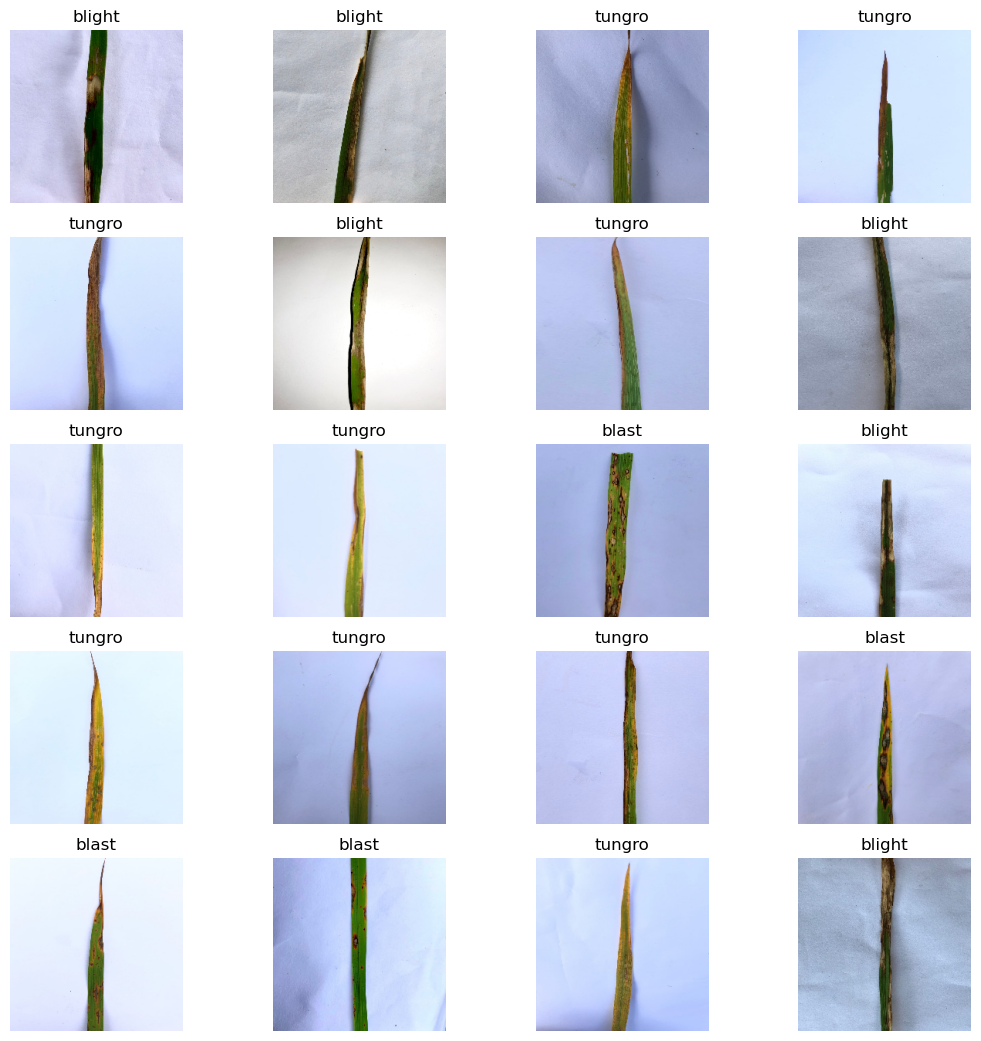

In [35]:
# Display a 4 by 4 grid of TRAINING images from a TensorFlow dataset created using tf.keras.utils.image_dataset_from_directory
figure = plt.figure(figsize=(13, 13))
for images, labels in train_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

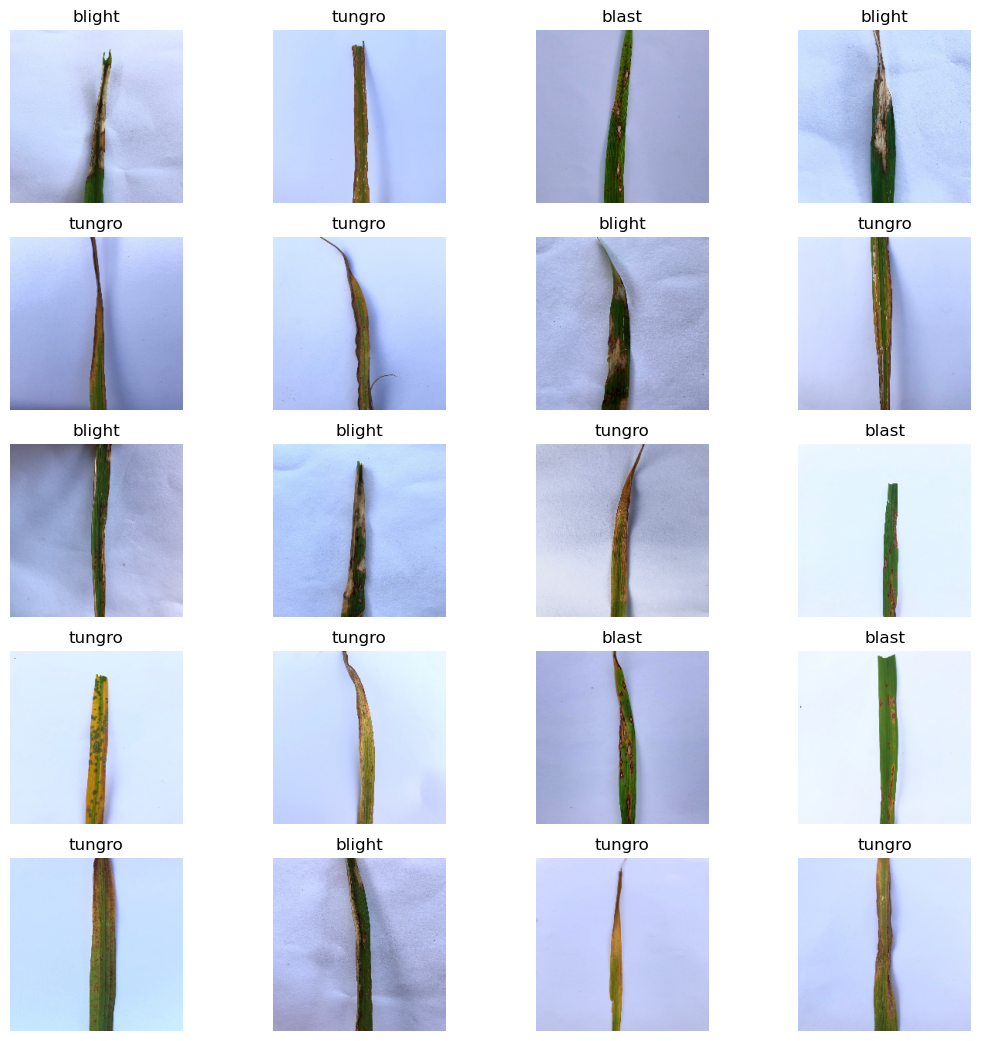

In [36]:
# Display a 4 by 4 grid of VALIDATION images from a TensorFlow dataset created using tf.keras.utils.image_dataset_from_directory
figure = plt.figure(figsize=(13, 13))
for images, labels in val_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [37]:
# Step 1: Create TensorFlow Dataset from Images Directory
def create_dataset(image_dir, image_size, batch_size):
    # Load and preprocess images from the directory
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    dataset = datagen.flow_from_directory(
        directory=image_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=None,  # We'll use this dataset for prediction, not classification
        shuffle=False     # Keep the order of images for bounding box predictions
    )
    return dataset

# Step 2: Define MobileNet Model for Feature Extraction
def create_mobilenet_model(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    
    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(4, name='bounding_box')(x)  # 4 values for bounding box (xmin, ymin, xmax, ymax)
    
    # Combine base model with custom head
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Step 3: Detect Rice Leaf Diseases and Provide Bounding Boxes
def detect_and_bbox(dataset, model):
    predictions = model.predict(dataset, verbose=1)
    return predictions


In [38]:
# Step 2: Define MobileNet Model
input_shape = (*image_size, 3)  # Shape of the input images
mobilenet_model = create_mobilenet_model(input_shape)

In [39]:
# Compile the MobileNet model with appropriate settings for transfer learning
mobilenet_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
                        #loss='mean_squared_error', metrics=['mse'])

num_epochs = 20
# Train the model and get the training history
#mobilenet_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
history = mobilenet_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)


Epoch 1/20
6/6 [==============================] - 7s 862ms/step - loss: 0.9453 - accuracy: 0.6146 - val_loss: 0.7350 - val_accuracy: 0.8125
Epoch 2/20
6/6 [==============================] - 5s 716ms/step - loss: 0.5034 - accuracy: 0.8229 - val_loss: 0.4225 - val_accuracy: 0.8542
Epoch 3/20
6/6 [==============================] - 5s 716ms/step - loss: 0.4500 - accuracy: 0.8229 - val_loss: 0.4503 - val_accuracy: 0.8542
Epoch 4/20
6/6 [==============================] - 5s 715ms/step - loss: 0.3163 - accuracy: 0.8490 - val_loss: 0.4704 - val_accuracy: 0.8958
Epoch 5/20
6/6 [==============================] - 5s 725ms/step - loss: 0.2278 - accuracy: 0.9115 - val_loss: 0.3913 - val_accuracy: 0.8750
Epoch 6/20
6/6 [==============================] - 5s 752ms/step - loss: 0.2170 - accuracy: 0.9167 - val_loss: 0.4212 - val_accuracy: 0.8750
Epoch 7/20
6/6 [==============================] - 5s 751ms/step - loss: 0.1754 - accuracy: 0.9427 - val_loss: 0.3689 - val_accuracy: 0.8958
Epoch 8/20
6/6 [====

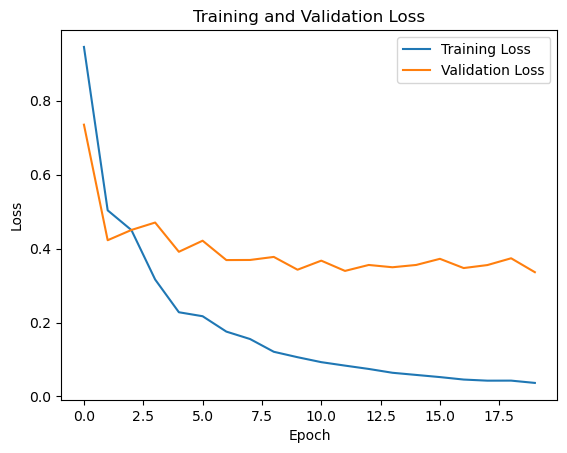

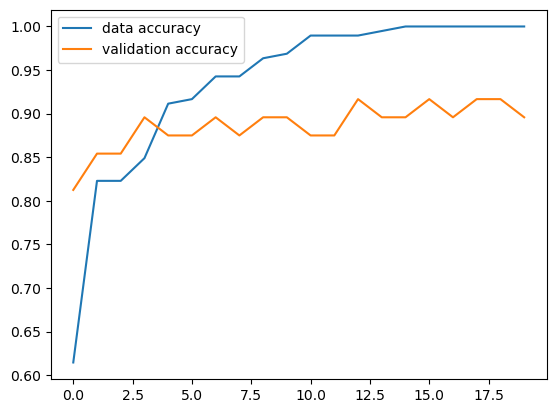

In [40]:
# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy vs validation accuracy
plt.plot(history.history['accuracy'], label='data accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [41]:
loss, accuracy = mobilenet_model.evaluate(val_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

2/2 [==============================] - 1s 257ms/step - loss: 0.3361 - accuracy: 0.8958
Validation Loss: 0.33609601855278015
Validation Accuracy: 0.8958333134651184


In [31]:
# Step 3: Detect Rice Leaf Diseases and Provide Bounding Boxes
predictions = detect_and_bbox(val_dataset, mobilenet_model)


2/2 [==============================] - 1s 235ms/step


1/1 [==============================] - 1s 574ms/step
Average Confusion Matrix:
[[68.  0.  0.]
 [ 0. 61.  0.]
 [ 0.  0. 63.]]


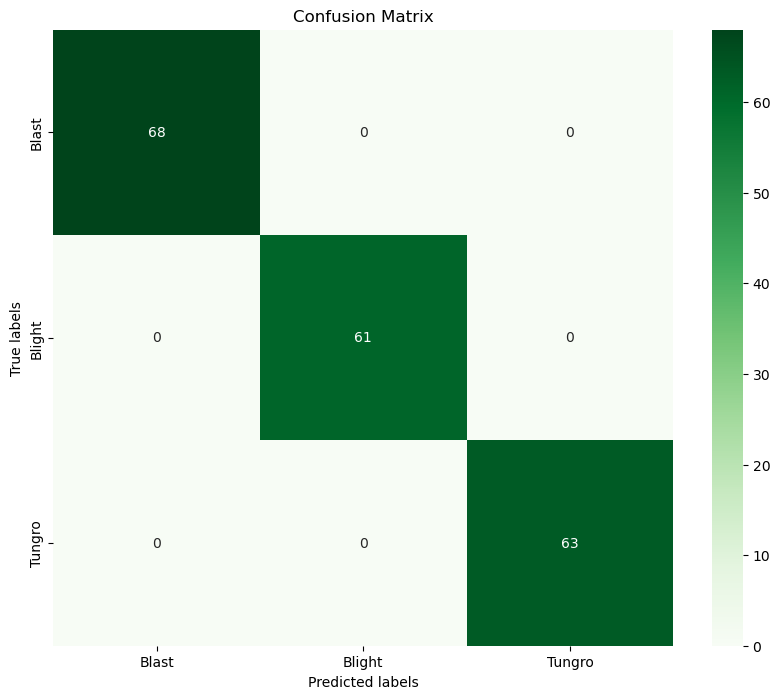

In [44]:
###DISPLAY AVERAGE CONFUSION MATRIX ON DATA TRAINING###
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix


# Example usage
num_runs = 5  # Number of runs to average over
dataset = train_dataset  # Your TensorFlow dataset
# model = tf.keras.models.load_model('model_class_13_balances_combined_ep_50.h5')  # Your trained TensorFlow model

def compute_confusion_matrix(mobilenet_model, dataset, num_runs):
    all_true_labels = []
    all_pred_labels = []

    for _ in range(num_runs):
        true_labels = []
        pred_labels = []

        # Make predictions on the dataset
        for features, labels in dataset:
            predictions = mobilenet_model.predict(features)
            true_labels.extend(labels.numpy())
            pred_labels.extend(np.argmax(predictions, axis=1))

        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    # Compute confusion matrix for each run
    all_conf_matrices = [confusion_matrix(true_labels, pred_labels) for true_labels, pred_labels in zip(all_true_labels, all_pred_labels)]

    # Average confusion matrices
    avg_conf_matrix = np.mean(all_conf_matrices, axis=0)

    return avg_conf_matrix

avg_conf_matrix = compute_confusion_matrix(mobilenet_model, dataset, num_runs)
print("Average Confusion Matrix:")
print(avg_conf_matrix)

# Convert the confusion matrix to integers
avg_conf_matrix = avg_conf_matrix.astype(int)

class_names=['Blast', 'Blight', 'Tungro']
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 270ms/step
Average Confusion Matrix:
[[12.  0.  0.]
 [ 0. 18.  1.]
 [ 1.  3. 13.]]


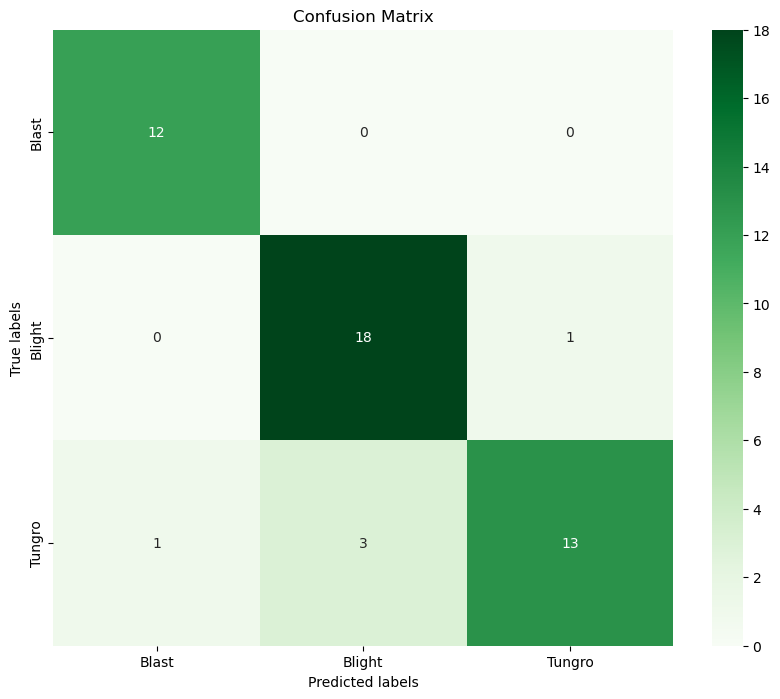

In [45]:
###DISPLAY AVERAGE CONFUSION MATRIX ON DATA VALIDATION###
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix


# Example usage
num_runs = 5  # Number of runs to average over
dataset = val_dataset  # Your TensorFlow dataset
# model = tf.keras.models.load_model('model_class_13_balances_combined_ep_50.h5')  # Your trained TensorFlow model

def compute_confusion_matrix(mobilenet_model, dataset, num_runs):
    all_true_labels = []
    all_pred_labels = []

    for _ in range(num_runs):
        true_labels = []
        pred_labels = []

        # Make predictions on the dataset
        for features, labels in dataset:
            predictions = mobilenet_model.predict(features)
            true_labels.extend(labels.numpy())
            pred_labels.extend(np.argmax(predictions, axis=1))

        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    # Compute confusion matrix for each run
    all_conf_matrices = [confusion_matrix(true_labels, pred_labels) for true_labels, pred_labels in zip(all_true_labels, all_pred_labels)]

    # Average confusion matrices
    avg_conf_matrix = np.mean(all_conf_matrices, axis=0)

    return avg_conf_matrix

avg_conf_matrix = compute_confusion_matrix(mobilenet_model, dataset, num_runs)
print("Average Confusion Matrix:")
print(avg_conf_matrix)

# Convert the confusion matrix to integers
avg_conf_matrix = avg_conf_matrix.astype(int)

class_names=['Blast', 'Blight', 'Tungro']
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [46]:
###DISPLAY CLASSIFICATION REPORT ON DATA TRAINING###

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import pandas as pd

# Example usage
num_runs = 5  # Number of runs to average over
dataset = train_dataset  # Your TensorFlow dataset
#model = tf.keras.models.load_model('model_class_13_balances_combined_ep_50.h5')  # Your trained TensorFlow model

def compute_classification_report(model, dataset):
    true_labels = []
    pred_labels = []

    # Make predictions on the dataset
    for features, labels in dataset:
        predictions = mobilenet_model.predict(features)
        true_labels.extend(labels.numpy())
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Compute classification report
    classification_report_str = classification_report(true_labels, pred_labels)
    return classification_report_str



# Compute classification report
classification_report_result = compute_classification_report(mobilenet_model, dataset)

# Display classification report
print("Classification Report:")
print(classification_report_result)


1/1 [==============================] - 1s 517ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        63

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



In [47]:
###DISPLAY CLASSIFICATION REPORT ON DATA VALIDATION/TESTING###

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import pandas as pd

# Example usage
num_runs = 5  # Number of runs to average over
dataset = val_dataset  # Your TensorFlow dataset
#model = tf.keras.models.load_model('model_class_13_balances_combined_ep_50.h5')  # Your trained TensorFlow model

def compute_classification_report(model, dataset):
    true_labels = []
    pred_labels = []

    # Make predictions on the dataset
    for features, labels in dataset:
        predictions = mobilenet_model.predict(features)
        true_labels.extend(labels.numpy())
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Compute classification report
    classification_report_str = classification_report(true_labels, pred_labels)
    return classification_report_str



# Compute classification report
classification_report_result = compute_classification_report(mobilenet_model, dataset)

# Display classification report
print("Classification Report:")
print(classification_report_result)

1/1 [==============================] - 0s 273ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.86      0.95      0.90        19
           2       0.93      0.76      0.84        17

    accuracy                           0.90        48
   macro avg       0.90      0.90      0.90        48
weighted avg       0.90      0.90      0.89        48

